c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.057700, Val Loss: 0.023212
Epoch 2/50, Train Loss: 0.006589, Val Loss: 0.010452
Epoch 3/50, Train Loss: 0.004544, Val Loss: 0.004275
Epoch 4/50, Train Loss: 0.003085, Val Loss: 0.003369
Epoch 5/50, Train Loss: 0.002555, Val Loss: 0.002789
Epoch 6/50, Train Loss: 0.002063, Val Loss: 0.002896
Epoch 7/50, Train Loss: 0.001625, Val Loss: 0.002589
Epoch 8/50, Train Loss: 0.001501, Val Loss: 0.002764
Epoch 9/50, Train Loss: 0.001289, Val Loss: 0.003066
Epoch 10/50, Train Loss: 0.001191, Val Loss: 0.002128
Epoch 11/50, Train Loss: 0.001079, Val Loss: 0.002121
Epoch 12/50, Train Loss: 0.000780, Val Loss: 0.003976
Epoch 13/50, Train Loss: 0.000789, Val Loss: 0.001840
Epoch 14/50, Train Loss: 0.001110, Val Loss: 0.005447
Epoch 15/50, Train Loss: 0.000739, Val Loss: 0.001951
Epoch 16/50, Train Loss: 0.000615, Val Loss: 0.002629
Epoch 17/50, Train Loss: 0.000572, Val Loss: 0.001578
Epoch 18/50, Train Loss: 0.000468, Val Loss: 0.005072
Epoch 19/50, Train Loss: 0.000533, Va

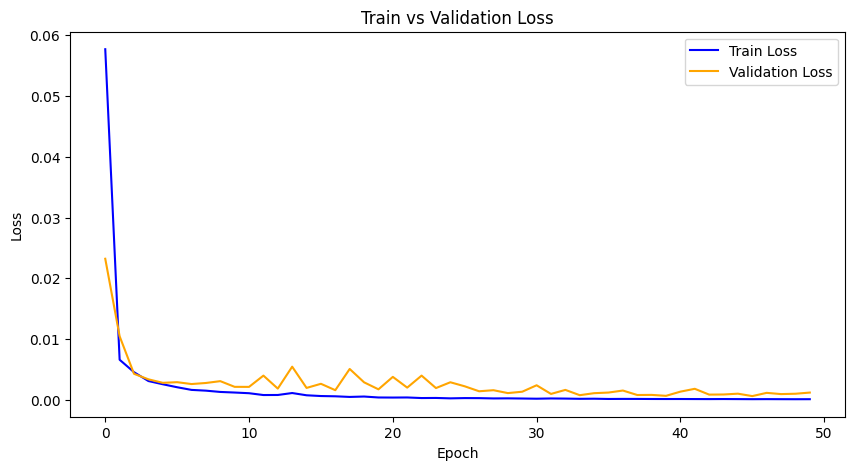

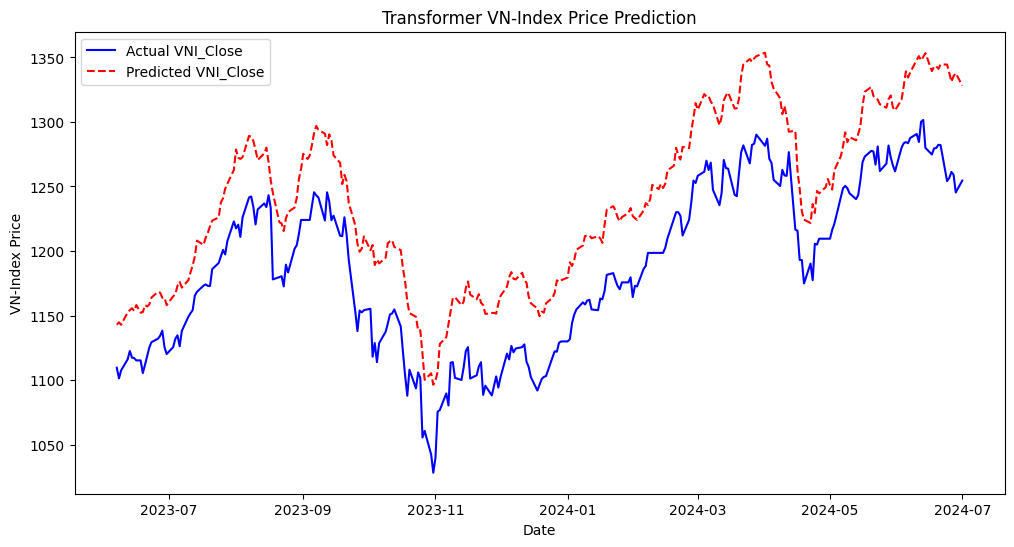

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# ƒê·ªçc d·ªØ li·ªáu
df = pd.read_csv(r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data.csv")

# Chuy·ªÉn ƒë·ªïi c·ªôt Date th√†nh datetime v√† ƒë·∫∑t l√†m index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)

# X√°c ƒë·ªãnh c·ªôt m·ª•c ti√™u v√† features
target_col = 'VNI_Close price'
feature_cols = [col for col in df.columns if col != target_col]

# Chu·∫©n h√≥a d·ªØ li·ªáu
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Chia t·∫≠p d·ªØ li·ªáu
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

# H√†m t·∫°o sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# T·∫°o d·ªØ li·ªáu
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# T·∫°o DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# M√¥ h√¨nh Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # L·∫•y vector cu·ªëi c√πng ƒë·ªÉ d·ª± ƒëo√°n
        out = self.fc(x)
        return out.squeeze()

# Kh·ªüi t·∫°o m√¥ h√¨nh
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

train_losses = []
val_losses = []

# Hu·∫•n luy·ªán m√¥ h√¨nh
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# L∆∞u m√¥ h√¨nh
torch.save(model.state_dict(), "transformer_advanced_2.pth")
print("‚úÖ Training ho√†n t·∫•t! M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u.")

# V·∫Ω bi·ªÉu ƒë·ªì Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# D·ª± ƒëo√°n tr√™n t·∫≠p test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

# Chuy·ªÉn v·ªÅ gi√° tr·ªã g·ªëc
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# V·∫Ω bi·ªÉu ƒë·ªì Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("Transformer VN-Index Price Prediction")
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√°
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Test MAE: 50.41
Test MSE: 2690.07
Test RMSE: 51.87


### **OUT OF SAMPLE PREDICTION**

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


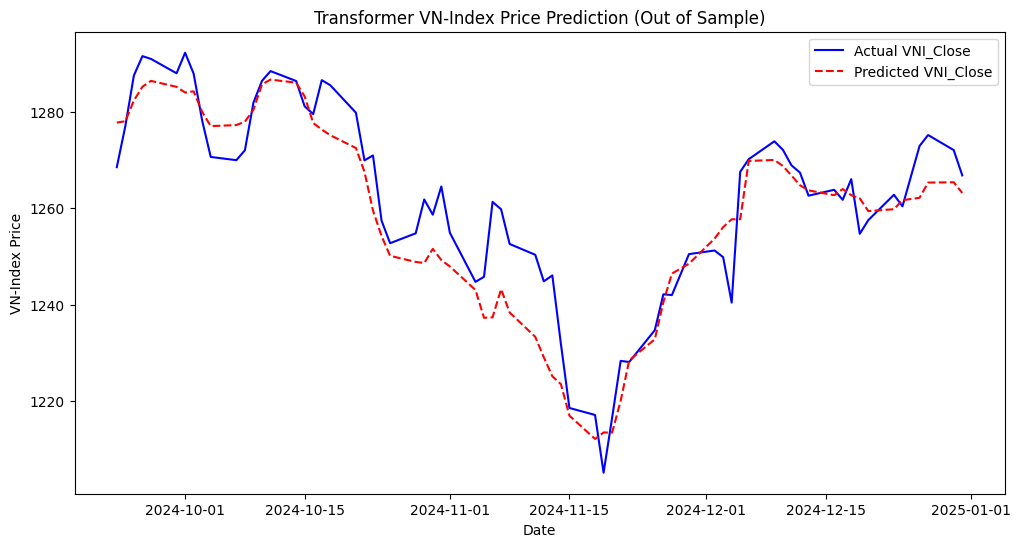

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_OOS_2.csv"
df_oos = pd.read_csv(file_path)

# Lo·∫°i b·ªè c√°c c·ªôt kh√¥ng c·∫ßn thi·∫øt
drop_cols = ['VNI_Open price', 'VNI_High price', 'VNI_Low price']
df_oos.drop(columns=drop_cols, inplace=True)

# Chuy·ªÉn ƒë·ªïi c·ªôt 'Date' th√†nh datetime v√† ƒë·∫∑t l√†m index
df_oos['Date'] = pd.to_datetime(df_oos['Date'], format="%m/%d/%Y")
df_oos.set_index('Date', inplace=True)

# X√°c ƒë·ªãnh c·ªôt m·ª•c ti√™u v√† features
target_col = "VNI_Close price"
feature_cols = [col for col in df_oos.columns if col != target_col]

# Chu·∫©n h√≥a d·ªØ li·ªáu (scale ri√™ng features v√† target)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df_oos_scaled = df_oos.copy()
df_oos_scaled[feature_cols] = scaler_features.fit_transform(df_oos[feature_cols])
df_oos_scaled[[target_col]] = scaler_target.fit_transform(df_oos[[target_col]])

# H√†m t·∫°o sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# T·∫°o d·ªØ li·ªáu OOS
seq_length = 60
X_oos, y_oos = create_sequences(df_oos_scaled, seq_length)

# -------------------- ƒê·ªãnh nghƒ©a M√¥ h√¨nh Transformer --------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # L·∫•y vector cu·ªëi c√πng ƒë·ªÉ d·ª± ƒëo√°n
        out = self.fc(x)
        return out.squeeze()

# -------------------- Load m√¥ h√¨nh ƒë√£ train --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_oos.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

# Load tr·ªçng s·ªë ƒë√£ hu·∫•n luy·ªán
model.load_state_dict(torch.load("transformer_advanced_2.pth", map_location=device))
model.eval()

# -------------------- D·ª± ƒëo√°n tr√™n t·∫≠p OOS --------------------
batch_size = 32
predictions_oos = []

with torch.no_grad():
    for i in range(0, len(X_oos), batch_size):
        batch_X = X_oos[i:i + batch_size].to(device)
        y_pred = model(batch_X).cpu().numpy()
        predictions_oos.extend(y_pred)

# Chuy·ªÉn v·ªÅ gi√° tr·ªã g·ªëc
predictions_oos = np.array(predictions_oos).reshape(-1, 1)
predictions_oos = scaler_target.inverse_transform(predictions_oos)

# Gi√° tr·ªã th·ª±c t·∫ø
actuals_oos = df_oos[target_col].iloc[-len(predictions_oos):].values.reshape(-1, 1)
# -------------------- T·∫°o DataFrame K·∫øt qu·∫£ --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
# -------------------- V·∫Ω bi·ªÉu ƒë·ªì Actual vs Predicted OOS --------------------
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results["Actual"], label="Actual VNI_Close", color='blue')
plt.plot(df_results.index, df_results["Predicted"], label="Predicted VNI_Close", color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.title("Transformer VN-Index Price Prediction (Out of Sample)")
plt.legend()
plt.show()

In [11]:

# -------------------- T√≠nh to√°n c√°c ch·ªâ s·ªë l·ªói --------------------
mae = mean_absolute_error(actuals_oos, predictions_oos)
mse = mean_squared_error(actuals_oos, predictions_oos)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actuals_oos - predictions_oos) / actuals_oos)) * 100

print(f"üìä MAE: {mae:.4f}")
print(f"üìä MSE: {mse:.4f}")
print(f"üìä RMSE: {rmse:.4f}")
print(f"üìä MAPE: {mape:.2f}%")

# -------------------- T·∫°o DataFrame K·∫øt qu·∫£ --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
print(df_results.head())



üìä MAE: 6.1475
üìä MSE: 65.3580
üìä RMSE: 8.0844
üìä MAPE: 0.49%
             Actual    Predicted     Error
Date                                      
2024-09-23  1268.48  1277.720215  9.240215
2024-09-24  1276.99  1278.003296  1.013296
2024-09-25  1287.48  1282.290039  5.189961
2024-09-26  1291.49  1285.147949  6.342051
2024-09-27  1290.92  1286.362305  4.557695


In [16]:
df_results

Actual    Predicted      Error
Date                                       
2024-09-23  1268.48  1277.720215   9.240215
2024-09-24  1276.99  1278.003296   1.013296
2024-09-25  1287.48  1282.290039   5.189961
2024-09-26  1291.49  1285.147949   6.342051
2024-09-27  1290.92  1286.362305   4.557695
...             ...          ...        ...
2024-12-24  1260.36  1261.638794   1.278794
2024-12-26  1272.87  1262.126221  10.743779
2024-12-27  1275.14  1265.288330   9.851670
2024-12-30  1272.02  1265.349854   6.670146
2024-12-31  1266.78  1263.137939   3.642061

[70 rows x 3 columns]

In [17]:
df_results.to_csv("transformer_advanced_OOS_predictions.csv")

Baseline RMSE: 0.0707


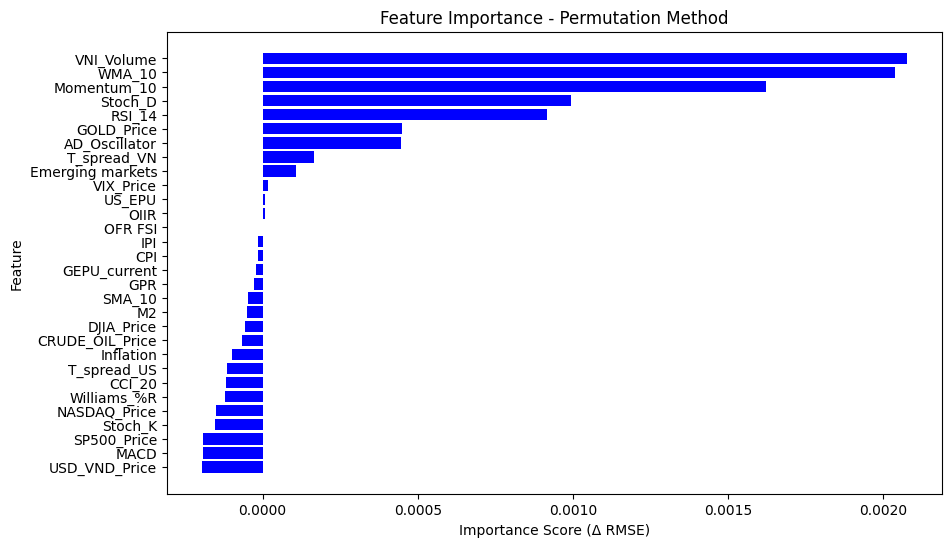

In [7]:
from sklearn.metrics import mean_squared_error
import copy

# D·ª± ƒëo√°n ban ƒë·∫ßu tr√™n t·∫≠p test (ƒë·ªÉ l·∫•y baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# T√≠nh Feature Importance b·∫±ng c√°ch ho√°n ƒë·ªïi t·ª´ng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # X√°o tr·ªôn feature th·ª© i

    # D·ª± ƒëo√°n l·∫°i
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # T√≠nh RMSE sau khi ho√°n ƒë·ªïi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature n√†o l√†m tƒÉng RMSE nhi·ªÅu l√† quan tr·ªçng h∆°n
    feature_importance[feature] = importance_score

# S·∫Øp x·∫øp theo ƒë·ªô quan tr·ªçng gi·∫£m d·∫ßn
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# V·∫Ω bi·ªÉu ƒë·ªì Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Œî RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # ƒê·∫£o ng∆∞·ª£c ƒë·ªÉ feature quan tr·ªçng nh·∫•t ·ªü tr√™n c√πng
plt.show()


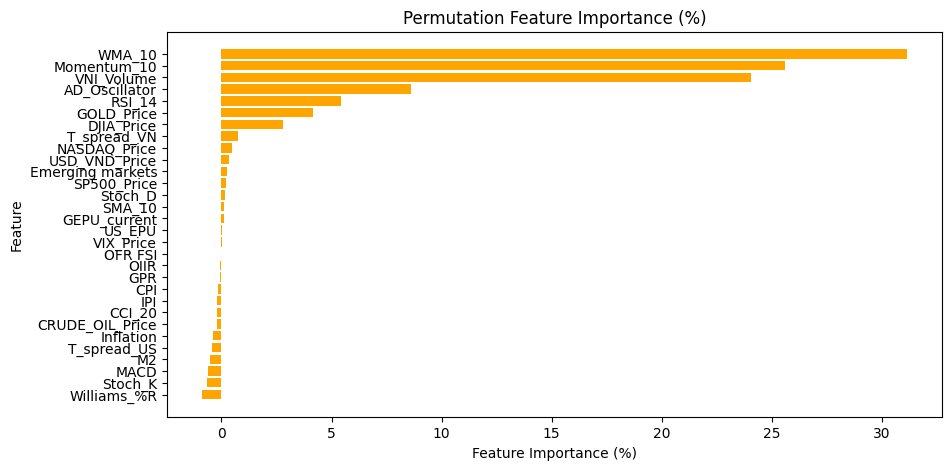

In [14]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_test, y_test, feature_cols, scaler_target):
    baseline_preds = model(X_test.to(device)).cpu().detach().numpy()
    baseline_preds = scaler_target.inverse_transform(baseline_preds.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1))
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importance_scores = {}

    for i, col in enumerate(feature_cols):
        X_test_permuted = X_test.clone()
        permuted_col = X_test_permuted[:, :, i]
        permuted_col[:] = permuted_col[torch.randperm(permuted_col.shape[0])]  # X√°o tr·ªôn gi√° tr·ªã c·ªôt

        permuted_preds = model(X_test_permuted.to(device)).cpu().detach().numpy()
        permuted_preds = scaler_target.inverse_transform(permuted_preds.reshape(-1, 1))

        permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_preds))
        importance_scores[col] = permuted_rmse - baseline_rmse  # Ch√™nh l·ªách RMSE

    # Chuy·ªÉn ƒë·ªïi sang % importance
    total_importance = sum(importance_scores.values())
    importance_percent = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

    return importance_percent

# Ch·∫°y t√≠nh to√°n importance
X_test_tensor, y_test_tensor = X_test.to(device), y_test.to(device)
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, feature_cols, scaler_target)
import matplotlib.pyplot as plt

# S·∫Øp x·∫øp feature importance theo gi√° tr·ªã gi·∫£m d·∫ßn
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_importance)

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(10, 5))
plt.barh(features, importance_values, color='orange')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (%)")
plt.gca().invert_yaxis()  # ƒê·∫£o ng∆∞·ª£c tr·ª•c Y ƒë·ªÉ feature quan tr·ªçng nh·∫•t n·∫±m tr√™n c√πng
plt.show()
